In [1]:
from madmex.wrappers import gwf_query
from madmex.util import join_dicts, parser_extra_args
from importlib import import_module
from datacube.api import GridWorkflow
from rasterio import features
import rasterio
import matplotlib.pyplot as plt
%matplotlib inline


Iteration #0
2019-08-05 21:23:32,511 - madmex.lcc.transform.irmad - irmad transform: Iteration #0
delta: 1.0
2019-08-05 21:23:32,513 - madmex.lcc.transform.irmad - irmad transform: delta: 1.0
Iteration #1
2019-08-05 21:23:36,782 - madmex.lcc.transform.irmad - irmad transform: Iteration #1
delta: 0.9905443438003421
2019-08-05 21:23:36,784 - madmex.lcc.transform.irmad - irmad transform: delta: 0.9905443438003421
Iteration #2
2019-08-05 21:23:41,044 - madmex.lcc.transform.irmad - irmad transform: Iteration #2
delta: 0.06061704721441119
2019-08-05 21:23:41,046 - madmex.lcc.transform.irmad - irmad transform: delta: 0.06061704721441119
Iteration #3
2019-08-05 21:23:45,551 - madmex.lcc.transform.irmad - irmad transform: Iteration #3
delta: 0.1238297821834865
2019-08-05 21:23:45,552 - madmex.lcc.transform.irmad - irmad transform: delta: 0.1238297821834865
Iteration #4
2019-08-05 21:23:49,749 - madmex.lcc.transform.irmad - irmad transform: Iteration #4
delta: 0.0654526431250142
2019-08-05 21:23

In [2]:
algorithm = 'imadmaf'
band_list = None
#name = 'test4_JAL_2017_2018'
product_pre = 'recipe_mex_L5L7_1011'
product_post = 'recipe_mex_L7L8_1415'
#lc_pre = 'land_cover_rf_s1_2_20mres10m_JAL_recipe2017'
#lc_post = 'land_cover_rf_s1_2_20m_resampled_10m_001_jalisco_2018_mxnb_31_02'
#year_pre = 2017
#year_post = 2018
#filter_labels = True
mmu = 5000.0

# Additional named arguments passed to the selected BiChange class constructor. These arguments have 
# to be passed in the form of key=value pairs inside a list. e.g.: ['arg1=12', 'arg2=0.2']
# The list of parameters corresponding to every implemented change detection algorithm can be retrieved
# using the antares bi_change_params command line:
#                 Argument | Default value
#       ================== | ==============
#                    array | -
#           max_iterations | 25
#                min_delta | 0.01
#                    lmbda | 0.0
#                    shift | (1, 1)
#                threshold | kapur
#                   kwargs | -
extra_args = parser_extra_args(['max_iterations=10', 'lmbda=0.001'])

#x = (-103.1011, -102.7029)
#y = (19.9939, 20.2467)
##options = {'lat': [20.833, 21.125], 'long': [-103.1395, -102.796], 'region': None}
#options = {'lat': [20.04, 20.401], 'long': [-103.1395, -102.796], 'region': None}
##options = {'lat': [20.04, 20.401], 'long': [-103.48275, -103.1395, 'region': None}
options = {'lat': [19.9939, 20.2467], 'long': [-103.1011, -102.7029], 'region': None}

In [3]:
# Build gwf_kwargs, send a query for both products, combine the dict and generate iterable
gwf_kwargs = { k: options[k] for k in ['lat', 'long', 'region']}
pre_dict = gwf_query(product_pre, view=False, **gwf_kwargs)
post_dict = gwf_query(product_post, view=False, **gwf_kwargs)
iterable = join_dicts(pre_dict, post_dict, join='inner').items()

#### Detect change

In [4]:
try:
    module = import_module('madmex.lcc.bitemporal.%s' % algorithm)
    BiChange = module.BiChange
except ImportError as e:
    raise ValueError('Invalid algorithm argument')

In [5]:
result = []
datacube_tile = []
failed =[]
fail_cause = []
for tiles in list(iterable):
    try:
        # Load geoarrays
        geoarray_pre = GridWorkflow.load(tiles[1][0], measurements=band_list)
        BiChange_pre = BiChange.from_geoarray(geoarray_pre, **extra_args)
        geoarray_post = GridWorkflow.load(tiles[1][1], measurements=band_list)
        BiChange_post = BiChange.from_geoarray(geoarray_post)
        # Run change detection
        BiChange_pre.run(BiChange_post)
        # Apply mmu filter
        if mmu is not None:
            BiChange_pre.filter_mmu(mmu)
        # Exit function if there are no changes left
        if BiChange_pre.change_array.sum() == 0:
            result.append(BiChange_pre.change_array)
            datacube_tile.append('change_array_{}_{}.tif'.format(tiles[0][0], tiles[0][1]))

        result.append(BiChange_pre.change_array)
        datacube_tile.append('change_array_{}_{}.tif'.format(tiles[0][0], tiles[0][1]))
    except Exception as e:
        fail_cause.append('Change detection failed because: %s' % e)
        failed.append('change_array_{}_{}.tif'.format(tiles[0][0], tiles[0][1]))

In [6]:
result[0].shape

(1667, 1667)

In [7]:
result[0].sum()

86100

In [8]:
result[0].size

2778889

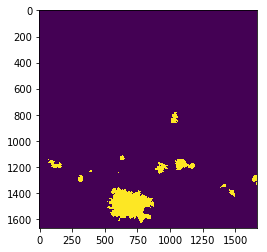

In [9]:
plt.imshow(result[0])